<a href="https://colab.research.google.com/github/marius44/Roary/blob/master/GNINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hi there!**

This is a Jupyter notebook for running molecular docking calculations with deep learning using Gnina docking software, which utilizes an ensemble of convolutional neural networks as a scoring function.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to perform drug binding structure prediction in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for docking calculations and MD simulations!** It is just simple docking pipeline illustrating each step of a docking and MD protocol.

---


**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/Cloud-Bind/issues

**Acknowledgments**
- We would like to thank the [GNINA](https://github.com/gnina/gnina) team for doing an excellent job open sourcing the software.
- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).
- We would like to thank [@ruiz_moreno_aj](https://twitter.com/ruiz_moreno_aj) for his work on [Jupyter Dock](https://github.com/AngelRuizMoreno/Jupyter_Dock)
- We would like to thank the ChemosimLab ([@ChemosimLab](https://twitter.com/ChemosimLab)) team for their incredible [ProLIF](https://prolif.readthedocs.io/en/latest/index.html#) (Protein-Ligand Interaction Fingerprints) tool.
- We would like to thank the [OpenBPMD](https://github.com/Gervasiolab/OpenBPMD) team for their open source implementation of binding pose metadynamics (BPMD).
- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.
- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.
- A Cloud-Bind by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes))

- For related notebooks see: [Cloud-Bind](https://github.com/pablo-arantes/Cloud-Bind)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
import tarfile
import os
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("pip install bio", shell=True)
subprocess.run("mamba install pytorch torchvision -c pytorch", shell=True)
subprocess.run("pip install torchani", shell=True)
subprocess.run("pip install ase", shell=True)
subprocess.run("mamba install -c conda-forge pdbfixer -y", shell=True)
subprocess.run("mamba install -c conda-forge parmed -y", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("mamba install -c conda-forge rdkit", shell=True)
subprocess.run("wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina", shell=True)
subprocess.run("chmod +x gnina", shell=True)
subprocess.run("wget https://github.com/rdk/p2rank/releases/download/2.4/p2rank_2.4.tar.gz", shell=True)
file = tarfile.open('p2rank_2.4.tar.gz')
file.extractall('/content/')
file.close()
os.remove('p2rank_2.4.tar.gz')

#load dependencies
import parmed as pmd
from biopandas.pdb import PandasPdb
import urllib.request
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors
from IPython.display import set_matplotlib_formats

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [3]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed.

**Important**: Make sure the PDB file points to the correct structure.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e. MyDrive/protein_ligand and so on.**

In [4]:
#@title **Please, provide the necessary input files below for receptor**:
#@markdown **Important:** Run the cell to prepare your receptor and select your reference residue for the construction of an optimal box size for the docking calculations.
from openmm.app.pdbfile import PDBFile

import warnings
warnings.filterwarnings('ignore')
import os
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.PDB import is_aa
import pandas as pd
from pdbfixer import PDBFixer

Google_Drive_Path = '/content/' #@param {type:"string"}
workDir = Google_Drive_Path

workDir2 = os.path.join(workDir)
workDir_check = os.path.exists(workDir2)
if workDir_check == False:
  os.mkdir(workDir2)
else:
  pass

if os.path.exists(os.path.join(workDir, "name_residues.txt")):
  os.remove(os.path.join(workDir, "name_residues.txt"))
  os.remove(os.path.join(workDir,"name_residues_receptor.txt"))
else:
  pass

temp = os.path.join(workDir, "temp.pdb")
receptor = os.path.join(workDir, "receptor.pdb")
ligand = os.path.join(workDir, "ligand.sdf")


Query_PDB_ID = '3HTB' #@param {type:"string"}

pdbfn = Query_PDB_ID + ".pdb"
url = 'https://files.rcsb.org/download/' + pdbfn
outfnm = os.path.join(workDir, pdbfn)
urllib.request.urlretrieve(url, outfnm)


ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.to_pdb(path=temp, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

#prepare receptor
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] != 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=receptor, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

fixer = PDBFixer(filename=receptor)
fixer.removeHeterogens()
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH=7.4)
PDBFile.writeFile(fixer.topology, fixer.positions, open(receptor, 'w'))


path = '/content/'


def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"

def aa(residue):
    res = residue.id[0]
    return res != "W"


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        return residue == self.residue and aa(residue)

def extract_ligands(path):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues.txt"), "a",))
          i += 1

extract_ligands(path)

def extract_ligands2(path):
    pdb = PDBParser().get_structure(receptor, receptor)
    io = PDBIO()
    io.set_structure(pdb)
    i2 = 1
    name_residues2 = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          # print(f"{chain[i].resname} {i}")
          name_residues2.append(residue)
          print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residues_receptor.txt"), "a",))
          i2 += 1

extract_ligands2(path)


dataset = pd.read_csv(os.path.join(workDir, 'name_residues.txt'), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

dataset2 = pd.read_csv(os.path.join(workDir, 'name_residues_receptor.txt'), delimiter = " ", header=None)
df2 = pd.DataFrame(dataset2)
df2 = df2.iloc[:, [2]]
new2 = df2.to_numpy()

b = 1
res_number = []
for j in new2:
  res_number.append(b)
  b += 1

print("Residue" + " - "  + "Number" )
a = 1
for j in new:
  print(', '.join(j) + " - "  + str(a))
  a += 1

Residue - Number
MET - 1
ASN - 2
ILE - 3
PHE - 4
GLU - 5
MET - 6
LEU - 7
ARG - 8
ILE - 9
ASP - 10
GLU - 11
GLY - 12
LEU - 13
ARG - 14
LEU - 15
LYS - 16
ILE - 17
TYR - 18
LYS - 19
ASP - 20
THR - 21
GLU - 22
GLY - 23
TYR - 24
TYR - 25
THR - 26
ILE - 27
GLY - 28
ILE - 29
GLY - 30
HIS - 31
LEU - 32
LEU - 33
THR - 34
LYS - 35
SER - 36
PRO - 37
ASP - 38
LEU - 39
ASN - 40
ALA - 41
ALA - 42
LYS - 43
SER - 44
GLU - 45
LEU - 46
ASP - 47
LYS - 48
ALA - 49
ILE - 50
GLY - 51
ARG - 52
ASN - 53
CYS - 54
ASN - 55
GLY - 56
VAL - 57
ILE - 58
THR - 59
LYS - 60
ASP - 61
GLU - 62
ALA - 63
GLU - 64
LYS - 65
LEU - 66
PHE - 67
ASN - 68
GLN - 69
ASP - 70
VAL - 71
ASP - 72
ALA - 73
ALA - 74
VAL - 75
ARG - 76
GLY - 77
ILE - 78
LEU - 79
ARG - 80
ASN - 81
ALA - 82
LYS - 83
LEU - 84
LYS - 85
PRO - 86
VAL - 87
TYR - 88
ASP - 89
SER - 90
LEU - 91
ASP - 92
ALA - 93
VAL - 94
ARG - 95
ARG - 96
CYS - 97
ALA - 98
ALA - 99
ILE - 100
ASN - 101
GLN - 102
VAL - 103
PHE - 104
GLN - 105
MET - 106
GLY - 107
GLU - 108
THR - 109
G

In [5]:
#@title **Predict ligand-binding pockets from your protein structure using P2Rank**:
#@markdown **P2Rank** is a stand-alone command line program that predicts ligand-binding pockets from a protein structure. It achieves high prediction success rates without relying on an external software for computation of complex features or on a database of known protein-ligand templates.
#@markdown P2Rank makes predictions by scoring and clustering points on the protein's solvent accessible surface. Ligandability score of individual points is determined by a machine learning based model trained on the dataset of known protein-ligand complexes. For more details see [here](https://github.com/rdk/p2rank).

import subprocess
import csv

output_p2rank = os.path.join(workDir, "output_p2rank")
p2rank = "/content/p2rank_2.4/prank predict -f " + str(receptor) + " -o " + str(output_p2rank)
original_stdout = sys.stdout
with open('p2rank.sh', 'w') as f:
  sys.stdout = f
  print(p2rank)
  sys.stdout = original_stdout
subprocess.run(["chmod 700 p2rank.sh"], shell=True)
subprocess.run(["./p2rank.sh"], shell=True,)

with open(os.path.join(workDir, "output_p2rank/receptor.pdb_predictions.csv"), 'r') as file:
  csvreader = csv.reader(file)
  residue = []
  score = []
  center_x = []
  center_y = []
  center_z = []
  for row in csvreader:
    residue.append(row[9:10])
    score.append(row[2:3])
    center_x.append(row[6:7])
    center_y.append(row[7:8])
    center_z.append(row[8:9])

for i in range(1,len(residue)):
  file = str((residue[i])[0]).split()
  score_end = str((score[i])[0]).split()
  center_x_end = str((center_x[i])[0]).split()
  center_y_end = str((center_y[i])[0]).split()
  center_z_end = str((center_z[i])[0]).split()
  print("Pocket " + str(i))
  print("Score = " + score_end[0])
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  print("Selected Residues = " + str(final_residues))
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")

Pocket 1
Score = 13.61
Selected Residues = [10, 103, 104, 105, 106, 107, 108, 11, 137, 138, 141, 142, 145, 18, 20, 21, 22, 24, 26, 30, 31, 32, 35, 70, 73, 74, 77]
Center x = 26.9061 Center y = -13.2369 Center z = -10.2065

Pocket 2
Score = 3.53
Selected Residues = [102, 103, 111, 118, 121, 153, 78, 84, 87, 88, 91, 99]
Center x = 22.5540 Center y = -25.4592 Center z = -2.7213

Pocket 3
Score = 2.13
Selected Residues = [100, 3, 71, 75, 88, 96, 97]
Center x = 14.4580 Center y = -23.6512 Center z = -13.2428



In [6]:
#@title **Please, provide the pocket or residue number for the selection**:
#@markdown **Important:** The selected pocket or residues will be used as a reference for the construction of an optimal box size for the ligand during the docking. If you want to select more than one residue, please, use comma to separte the numbers (i.e. 147,150,155,160). **Please, DO NOT USE SPACES BETWEEN THEM.**

import re
import csv

if os.path.exists(os.path.join(workDir, "name_residue.txt")):
  os.remove(os.path.join(workDir, "name_residue.txt"))
else:
  pass

# Python code to convert string to list
def Convert(string):
	li = list(string.split(","))
	return li

def extract_ligands(path,residues):
    pdb = PDBParser().get_structure(temp, temp)
    io = PDBIO()
    io.set_structure(pdb)
    i = 1
    name_residues = []
    for model in pdb:
      for chain in model:
        for residue in chain:
          if not aa(residue):
            continue
          if i == int(residues):
            # print(residues)
            print((f"saving {residue}"), file=open(os.path.join(workDir, "name_residue.txt"), "a",))
            io.save(f"res_{i}_certo.pdb", ResidueSelect(chain, residue))
          i += 1

Selection = "Pocket" #@param ["Pocket", "Residues"]

number = '3' #@param {type:"string"}

if Selection == "Pocket":
  file = str((residue[int(number)])[0]).split()
  score_end = str((score[int(number)])[0]).split()
  center_x_end = str((center_x[int(number)])[0]).split()
  center_y_end = str((center_y[int(number)])[0]).split()
  center_z_end = str((center_z[int(number)])[0]).split()
  center_x_gnina = float(center_x_end[0])
  center_y_gnina = float(center_y_end[0])
  center_z_gnina = float(center_z_end[0])
  print("Pocket " + str(number))
  print("Score = " + score_end[0])
  print("Center x = "+ str(center_x_end[0]), "Center y = "+ str(center_y_end[0]), "Center z = "+ str(center_z_end[0]) + "\n")
  final_residues = []
  for i in range(0,len(file)):
    test = file[i]
    final_residues.append(int(test[2:]))
  residues_num = final_residues
else:
  residues_num = Convert(number)

filenames=[]
for k in range(0, len(residues_num)):
  extract_ligands(path, residues_num[k])
  filenames.append(f"res_{residues_num[k]}_certo.pdb")


with open('selection_merge.pdb', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

# reading each line from original
# text file
file1 = open('/content/selection_merge.pdb', 'r')
file2 = open('/content/selection_merge_end.pdb','w')

for line in file1.readlines():

    # reading all lines that begin
    # with "TextGenerator"
    x = re.findall("^END", line)

    if not x:
        file2.write(line)

# close and save the files
file1.close()
file2.close()

dataset = pd.read_csv(os.path.join(workDir, "name_residue.txt"), delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df.iloc[:, [2]]
new = df.to_numpy()

print("Selected Residue" + " - "  + "Number" )
for j, i in zip(new, range(0, len(residues_num))):
# for j in new:
  print(', '.join(j) + " - "  + str(residues_num[i]))
res_box = '/content/selection_merge_end.pdb'

Pocket 3
Score = 2.13
Center x = 14.4580 Center y = -23.6512 Center z = -13.2428

Selected Residue - Number
ILE - 100
ILE - 3
VAL - 71
VAL - 75
TYR - 88
ARG - 96
CYS - 97


In [7]:
#@title **Receptor Visualization**:
#@markdown Now the protein has been sanitized and the selection has been chosen, it would be recomended to visualize and check the protein (gray) and your selection (green).

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open(receptor,'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open(res_box,'r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Smiles: CCCC1=CC=CC=C1O


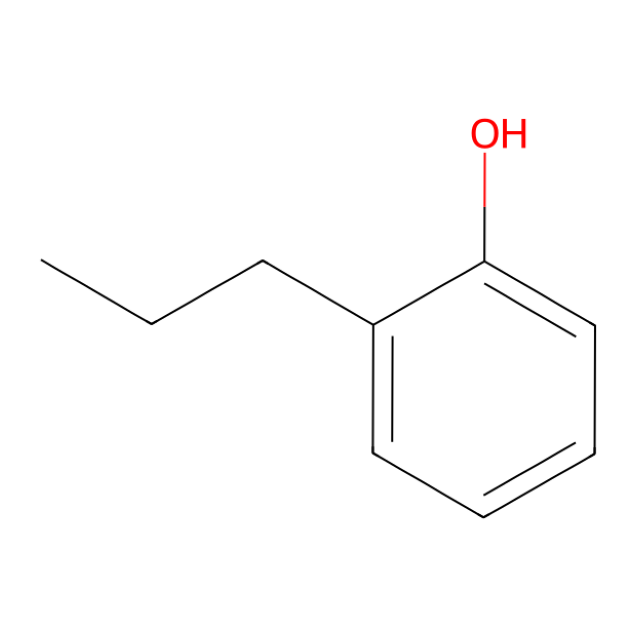

In [8]:
#@title **Please, provide the necessary input files for the ligand**:

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol**

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab or in your Google Drive.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import matplotlib.image as mpimg

import os

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'CCCC1=CC=CC=C1O' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
elif Type == "pdb":
  pdb_name = os.path.join(workDir, smiles_or_filename)
  mol= [m for m in pybel.readfile(filename=pdb_name, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))
else:
  mol_name = os.path.join(workDir, smiles_or_filename)
  mol = Chem.MolFromMolFile(mol_name)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
  AllChem.EmbedMolecule(hmol)
  hmol.GetConformer(0)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  # Optimize
  AllChem.OptimizeMoleculeConfs(hmol, ff, numThreads=1, maxIters=1000)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, "ligand.mol")))
  AllChem.MolToPDBFile(hmol, (os.path.join(workDir, "ligand.pdb")))

print("Smiles: " + str(Smiles))
smi = Draw.MolToFile(smiles_fig, size=(600, 600), filename=os.path.join(workDir,str(Smiles) + '.png'))
img = mpimg.imread(os.path.join(workDir,str(Smiles) + '.png'))
plt.figure(figsize = (8,8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from openbabel import pybel
from torchani.units import HARTREE_TO_KCALMOL


#@title **Ligand geometry optimization using TorchANI**:

#@markdown Geometry optimization for the ligand 3D structure, using ANI-1x, ANI-1ccx or ANI-2x as the optimizing engine.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species

mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand.mol")), removeHs=False)
mol = io.read(os.path.join(workDir, "ligand.mol"))
coordinates, species = mol2arr([mol_deg], device)
tensor1 = coordinates.detach().numpy()
atoms = Atoms(mol, positions=tensor1[0])
atoms.center(vacuum=3.0)
atoms.set_calculator(calculator)
print("Begin Geometry Optimization ")
opt = BFGS(atoms)
opt.run(fmax=opt_tol)
# print()
write((os.path.join(workDir, "ligand_min.xyz")), format="xyz", images=atoms)

atomic_symbols = []
xyz_coordinates = []

with open((os.path.join(workDir, "ligand_min.xyz")), "r") as file:
  for line_number,line in enumerate(file):
      if line_number == 0:
          num_atoms = int(line)
      elif line_number == 1:
          comment = line # might have useful information
      else:
          atomic_symbol, x, y, z = line.split()
          atomic_symbols.append(atomic_symbol)
          xyz_coordinates.append([float(x),float(y),float(z)])

from rdkit.Geometry import Point3D
conf = mol_deg.GetConformer()

for i in range(mol_deg.GetNumAtoms()):
  x,y,z = xyz_coordinates[i]
  conf.SetAtomPosition(i,Point3D(x,y,z))
AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "ligand_min.mol")))
AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "ligand_min.pdb")))
#convert to sdf format
mol= [m for m in pybel.readfile(filename=os.path.join(workDir, "ligand_min.mol"), format='mol')][0]
out=pybel.Outputfile(filename=ligand,format='sdf',overwrite=True)
out.write(mol)
out.close()


#TorchANI Energies
mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "ligand_min.mol")), removeHs=False)
coordinates, species = mol2arr([mol_deg], device)
energy = model((species, coordinates)).energies
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
force = -derivative
print('Energy:', energy.item())
# print('Force:', force.squeeze())

/usr/local/lib/python3.11/site-packages/torchani/resources/
/usr/local/lib/python3.11/site-packages/torchani/resources/
Model = ANI2x
Begin Geometry Optimization 
      Step     Time          Energy          fmax
BFGS:    0 22:45:34   -11572.880375        0.593414
BFGS:    1 22:45:34   -11572.889521        0.340125
BFGS:    2 22:45:35   -11572.895151        0.189008
BFGS:    3 22:45:35   -11572.902608        0.232656
BFGS:    4 22:45:35   -11572.905883        0.217419
BFGS:    5 22:45:35   -11572.908245        0.106978
BFGS:    6 22:45:35   -11572.909494        0.071626
BFGS:    7 22:45:35   -11572.910566        0.101530
BFGS:    8 22:45:35   -11572.911369        0.081761
BFGS:    9 22:45:35   -11572.912055        0.083755
BFGS:   10 22:45:35   -11572.912764        0.086777
BFGS:   11 22:45:35   -11572.913549        0.087134
BFGS:   12 22:45:35   -11572.914110        0.065134
BFGS:   13 22:45:35   -11572.914428        0.050752
BFGS:   14 22:45:35   -11572.914619        0.039007
BFGS:  

In [10]:
#@title **Ligand Visualization**:
#@markdown Now the ligand has been optimized, it would be recomended to visualize and check the ligand.

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

# view.addModel(open(receptor,'r').read(),format='pdb')
# Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open(ligand,'r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
#@title **Parameters for the docking calculation:**
Output_name = 'output_docking' #@param {type:"string"}
#@markdown Amount of buffer space to add the generated box (Angstroms):
size = 5 #@param {type:"slider", min:1, max:20, step:1}

#@markdown Exhaustiveness of the global search (roughly proportional to time):
exhaustiveness = 48 #@param {type:"slider", min:2, max:64, step:2}

#@markdown Explicit random seed:
seed = "0" #@param {type:"string"}

#@markdown Convolutional neural network (CNN) parameter:

cnn_scoring = "rescore (default)" #@param ["none", "rescore (default)", "refinement", "all"]
if cnn_scoring == "rescore (default)":
  cnn_scoring = "rescore"
  scoring_vinardo = " "
elif cnn_scoring == "none":
  scoring_vinardo = " --scoring vinardo "
else:
  scoring_vinardo = " "

# if cnn_scoring == "none":
#   scoring_vinardo = " --scoring vinardo "
# else:
#   scoring_vinardo = " "

#@markdown **cnn_scoring** determines at what points of the docking procedure that the CNN scoring function is used.

#@markdown **none** - No CNNs used for docking. Here, uses all the empirical scoring from [Vinardo](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0155183) scoring function.

#@markdown **rescore** (default) - CNN used for reranking of final poses. Least computationally expensive CNN option.

#@markdown **refinement** - CNN used to refine poses after Monte Carlo chains and for final ranking of output poses. 10x slower than rescore when using a GPU.

#@markdown **all** - CNN used as the scoring function throughout the whole procedure. Extremely computationally intensive and not recommended.

#@markdown The default CNN scoring function is an ensemble of 5 models selected to balance pose prediction performance and runtime: dense, general_default2018_3, dense_3, crossdock_default2018, and redock_default2018.

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

docking_output_gz = os.path.join(workDir, Output_name + ".sdf.gz")
docking_output = os.path.join(workDir, Output_name + ".sdf")

if os.path.exists(docking_output_gz):
  os.remove(docking_output_gz)
elif os.path.exists(docking_output):
  os.remove(docking_output)
else:
  pass


if Selection == "Pocket":
  gnina = "./gnina -r " + str(receptor) + " -l " +  str(ligand) + " --center_x " + str(center_x_gnina) +  " --center_y " + str(center_y_gnina) +  " --center_z " + str(center_z_gnina) + " --size_x " + str(size) +  " --size_y " + str(size) +  " --size_z " + str(size) + " --cnn_scoring " + str(cnn_scoring) + " --exhaustiveness " + str(exhaustiveness) + " -o " + str(docking_output_gz) + str(scoring_vinardo) +  "--num_modes 10 " + "--seed " + str(int(seed))
else:
  gnina = "./gnina -r " + str(receptor) + " -l " +  str(ligand) + " --autobox_ligand " + str(res_box) +  " --autobox_add " + str(size) + " --cnn_scoring " + str(cnn_scoring) + " --exhaustiveness " + str(exhaustiveness) + " -o " + str(docking_output_gz) + str(scoring_vinardo) +  "--num_modes 10 " + "--seed " + str(int(seed))

zip_gnina = "gunzip " + str(docking_output_gz)

original_stdout = sys.stdout # Save a reference to the original standard output
with open('gnina.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gnina)
    print(zip_gnina)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gnina.sh 2>&1 1>/dev/null
!bash gnina.sh

import gzip
v = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
v.setViewStyle({'style':'outline','color':'black','width':0.05})
v.addModel(open(receptor).read())
v.setStyle({'cartoon':{},'stick':{'colorscheme':'white','radius':.1}})
v.addModel(open(res_box).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.175}})
v.addModelsAsFrames(open(docking_output,'rt').read())
v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
v.animate({'interval':1000})
v.zoomTo({'model':1})
v.rotate(90)

              _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/receptor.pdb -l /content/ligand.sdf --center_x 14.458 --center_y -23.6512 --center_z -13.2428 --size_x 5 --size_y 5 --size_z 5 --cnn_scoring rescore --exhaustiveness 48 -o /content/output_docking.sdf.gz --num_modes 10 --seed 0
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
 | pose 0 | initial pose not within box
 | pose 0 | ligand outside box
 | pose 0 | ligand outside box
 | pose 0 | ligand outside box

mode |  affinity  |    CNN     |   CNN
     | (kcal/mol) | pose score | affin

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

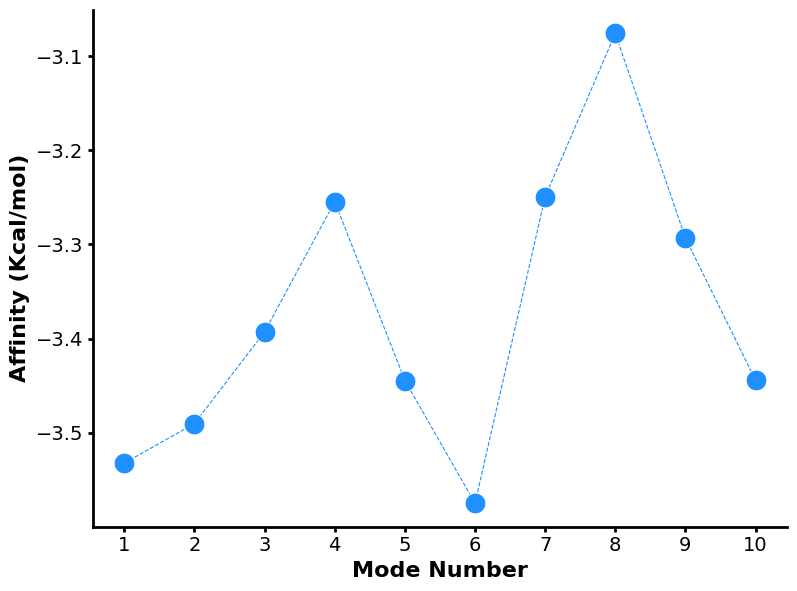

In [14]:
import pandas as pd
from rdkit.Chem import rdFMCS,AllChem, Draw, PandasTools
import seaborn as sns
#@title **Docking Analysis:**
Parameter = "Affinity" #@param ["Affinity", "CNN pose score", "CNN affinity"]

Output_name = 'Affinity' #@param {type:"string"}

VinaPoses=PandasTools.LoadSDF(docking_output)

AllPoses=pd.concat([VinaPoses])
# AllPoses.sort_values(by='CNNscore',inplace=False)
# AllPoses['minimizedAffinity']=[float(i) for i in AllPoses['minimizedAffinity']]
# AllPoses.sort_values(by='minimizedAffinity',inplace=True, ascending=False)
# AllPoses.reset_index(drop=True, inplace=True)
# x='CNNscore'

parameter = Parameter
if parameter == "Affinity":
  AllPoses['minimizedAffinity']=[float(i) for i in AllPoses['minimizedAffinity']]
  y='minimizedAffinity'
elif parameter == "CNN pose score":
  AllPoses['CNNscore']=[float(i) for i in AllPoses['CNNscore']]
  y='CNNscore'
else:
  AllPoses['CNNaffinity']=[float(i) for i in AllPoses['CNNaffinity']]
  y='CNNaffinity'

plt.rcParams['axes.linewidth'] = 2
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
# print(AllPoses)

a = 0
x_new =[]
for i in AllPoses['minimizedAffinity']:
  a = a + 1
  x_new.append(a)

# Keyword arguments for styling the plot
kwargs = dict (linestyle='--', color='dodgerblue', marker ='o', linewidth=0.8, markersize=15)

# Draw the plot
line = sns.lineplot(x=x_new,y=y, data=AllPoses,**kwargs)

if parameter == "Affinity":
  plt.ylabel('Affinity (Kcal/mol)',fontsize=16,fontweight='bold')
elif parameter == "CNN pose score":
  plt.ylabel('CNN pose score',fontsize=16,fontweight='bold')
else:
  plt.ylabel('CNN affinity',fontsize=16,fontweight='bold')

plt.xlabel('Mode Number',fontsize=16,fontweight='bold')
plt.xticks(x_new[::1], fontsize = 12) # set divisor
plt.yticks(fontsize = 12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=14)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [16]:
#@title **Best pose selection:**

mode_number = "8" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.05})

view.addModel(open(receptor,'r').read(),'pdb')
Prot=view.getModel()
# Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'},'stick':{'radius':.1}})
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.2,'color':'white'})


view.addModel(open(res_box,'r').read(),'pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'grayCarbon','radius':0.2}})


results=Chem.SDMolSupplier(docking_output,True)
p=Chem.MolToMolBlock(results[(int(mode_number)-1)],False)
p2=Chem.MolToMolFile(results[(int(mode_number)-1)],(os.path.join(workDir, str(int(mode_number)) + "_pose.sdf")))

print('Reference: Gray | gnina Pose: Green')
if cnn_scoring == "none":
  print ('Affinity: {}'.format(results[(int(mode_number)-1)].GetProp('minimizedAffinity')))
else:
  print ('Affinity: {}'.format(results[(int(mode_number)-1)].GetProp('minimizedAffinity')))
  print ('CNN Score: {}'.format(results[(int(mode_number)-1)].GetProp('CNNscore')))
  print ('CNN Affinity: {}'.format(results[(int(mode_number)-1)].GetProp('CNNaffinity')))

view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

Reference: Gray | gnina Pose: Green
Affinity: -3.44435
CNN Score: 0.6497286558
CNN Affinity: 3.2782108784


[23:14:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:14:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:14:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:14:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[23:14:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.